# <font color='purple'>ML Prediction - CNN for image classification </font>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras import layers
#from keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, Callback
import cv2
from os import listdir
from os.path import isfile, join
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/proj_DS"

/content/drive/MyDrive/proj_DS


In [ ]:
DIR = '/content/drive/MyDrive/proj_DS/train'
test_DIR = '/content/drive/MyDrive/proj_DS/test'

In [ ]:
!unzip foods_final.zip

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.3, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
 DIR,
 target_size = (160,160),
 color_mode = 'rgb',
 batch_size = 32,
 class_mode = 'categorical',
 shuffle = True,
 seed = 42, 
 subset = "training"
)

validation_generator = train_datagen.flow_from_directory(
 DIR,
 target_size = (160,160),
 color_mode = 'rgb',
 batch_size = 32,
 class_mode = 'categorical',
 shuffle = True,
 seed = 42, 
 subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
 '/content/drive/MyDrive/proj_DS/test',
 target_size = (160,160),
 color_mode = 'rgb',
 batch_size = 10,
 class_mode = 'categorical',
 shuffle = False,
 seed =42
)

Found 22228 images belonging to 6 classes.
Found 9523 images belonging to 6 classes.
Found 3525 images belonging to 1 classes.


In [ ]:
# lables the model will give to each class
label_map = (train_generator.class_indices)
label_map

{'cakes_cupcakes_snack_cakes': 0,
 'candy': 1,
 'chips_pretzels_snacks': 2,
 'chocolate': 3,
 'cookies_biscuits': 4,
 'popcorn_peanuts_seeds_related_snacks': 5}

# Train model

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False,input_shape = (160, 160, 3))
l = base_model.output
l = GlobalAveragePooling2D()(l)
out = Dense(6, activation="softmax")(l)
model = Model(inputs = base_model.input, outputs = out)
#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')
# compile
model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=['accuracy'])


17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
history = model.fit(train_generator,steps_per_epoch=2250/64,
                              validation_data=validation_generator,validation_steps=750/64, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping])

# Evaluate model

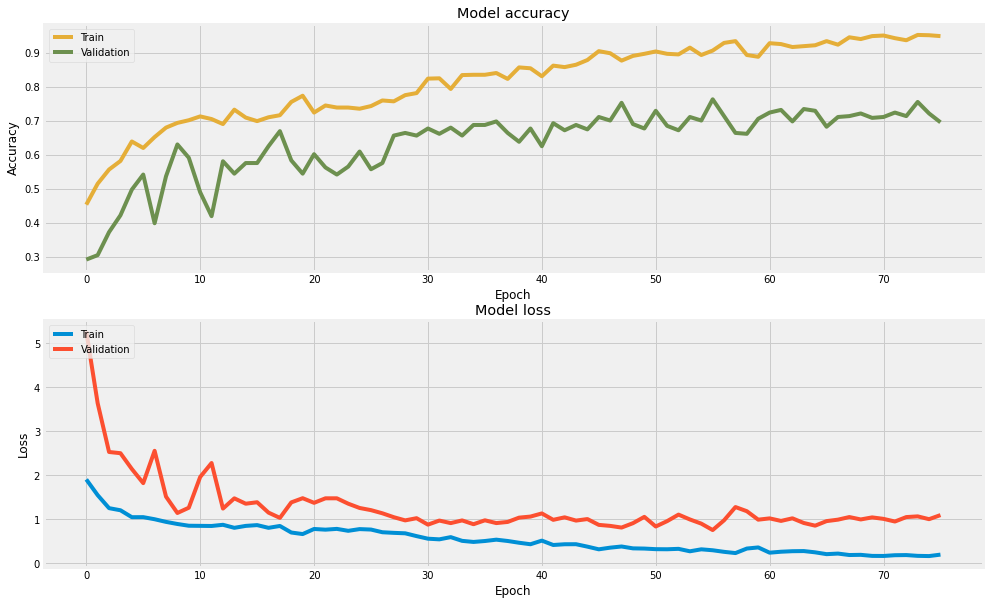

In [ ]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    
plot_hist(history)

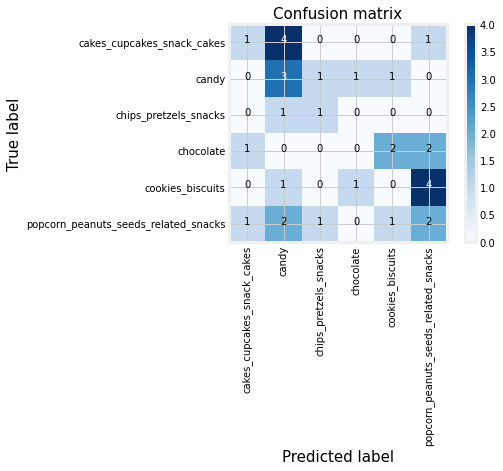

In [ ]:
x_test, y_test = validation_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes= ["cakes_cupcakes_snack_cakes", "candy", "chips_pretzels_snacks", "chocolate" , "cookies_biscuits", "popcorn_peanuts_seeds_related_snacks"]
    plt.xticks([0,1,2,3,4,5], classes, fontsize=10, rotation='vertical')
    plt.yticks([0,1,2,3,4,5], classes, fontsize=10,verticalalignment="center", rotation='horizontal')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

# Get predictions

In [ ]:
def get_predictions_of_dir(mypath, dst):
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  table = pd.DataFrame({'img':[], "prediction":[]})
  for file in onlyfiles:
    img =cv2.imread(f"{mypath}/{file}")
    resize = tf.image.resize(img, (160,160))
    yhat = np.argmax(model.predict(np.expand_dims(resize/255, 0)))
    table.loc[len(table.index)] = [int(file[:-4]), yhat]
  table.to_csv(dst, encoding = 'utf-8-sig', index =False) 
  files.download(dst)
  return(table)


In [ ]:
test_table = get_predictions_of_dir('/content/drive/MyDrive/proj_DS/test/test_check', 'test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
popcorn_table = get_predictions_of_dir('/content/drive/MyDrive/proj_DS/train/popcorn_peanuts_seeds_related_snacks', 'popcorn_peanuts_seeds_related_snacks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cookies_biscuits_table = get_predictions_of_dir('/content/drive/MyDrive/proj_DS/train/cookies_biscuits', 'cookies_biscuits.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chocolate_table = get_predictions_of_dir('/content/drive/MyDrive/proj_DS/train/chocolate', 'chocolate.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chips_table = get_predictions_of_dir('/content/drive/MyDrive/proj_DS/train/chips_pretzels_snacks', 'chips_pretzels_snacks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
candy_table = get_predictions_of_dir('/content/drive/MyDrive/proj_DS/train/candy', 'candy.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cake_table = get_predictions_of_dir('/content/drive/MyDrive/proj_DS/train/cakes_cupcakes_snack_cakes', 'cakes_cupcakes_snack_cakes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# summary

The model that we present here is thr last model we tried. <br>
Prior to it we tried many different models with different hyperparemetrs ,such as :number of epochs, number of layers, with/without dropouts, different activation map and more. <br>
All the other models gave us accuracy of 25%-40%.
we had our 'breakthrough' when we tried to use weights from imagenet. Using those weights improved our prediction to around 70% accuracy, and we decided it's a good enough accuracy for us to use it in our main neural network.